In [1]:
import pandas as pd
df_titanic = pd.read_excel('titanic.xlsx', sheet_name='train')

Оцениваем качество исходных данных, проверяем на пустые значения и общую релевантность

In [2]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Целевая переменная  1295 non-null   float64
 1   Социальный класс    1295 non-null   float64
 2   Пол                 1295 non-null   object 
 3   Возраст             1034 non-null   float64
 4   БСС                 1295 non-null   float64
 5   РД                  1295 non-null   float64
 6   Номер билета        1295 non-null   object 
 7   Стоимость проезда   1294 non-null   float64
 8   Место               290 non-null    object 
 9   Порт посадки        1293 non-null   object 
 10  Лодка               479 non-null    object 
 11  Unnamed: 11         0 non-null      float64
 12  −                   0 non-null      float64
dtypes: float64(8), object(5)
memory usage: 133.1+ KB


In [3]:
# удаляем нерелевантные столбцы данных
df_titanic = df_titanic.drop(columns=['Unnamed: 11'], axis=1)
df_titanic = df_titanic.drop(columns=['−'], axis=1)

# признак Лодки будет вредить модели, так как человек в лодке явно выжил - в списке фичей я данный признак и так не буду использовать, но обычно их удаляю заранее во избежании случайного занесения мной или еще кем-то
df_titanic = df_titanic.drop(columns=['Лодка'], axis=1)

# теперь нам надо заполнить остальные пропуски, классический вариант для работы с датасетом титаника это извлечение номера палубы из номера места (номер палубы - первая буква в номере места [0])
df_titanic['deck'] = df_titanic['Место'].apply(lambda x: str(x)[0] if pd.notna(x) and x != '' else 'U')
df_titanic = df_titanic.drop(columns=['Место'], axis=1)

# пропуски возраста заполним медианными значениями на основе пола и соц класса
df_titanic['Возраст'] = df_titanic['Возраст'].fillna(df_titanic.groupby(['Пол', 'Социальный класс'])['Возраст'].transform('median'))

# Порт посадки и Стоимость проезда - порт заполним наиболее часто встречающимся значением, а стоимость проезда медианой по соц классу
df_titanic['Стоимость проезда'] = df_titanic['Стоимость проезда'].fillna(df_titanic.groupby(['Социальный класс'])['Стоимость проезда'].transform('median'))
df_titanic['Порт посадки'] = df_titanic['Порт посадки'].fillna(df_titanic['Порт посадки'].mode()[0])

# удаляем строки, где отсутствует целевая переменная
df_titanic = df_titanic.dropna()

df_titanic.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Целевая переменная  1295 non-null   float64
 1   Социальный класс    1295 non-null   float64
 2   Пол                 1295 non-null   object 
 3   Возраст             1295 non-null   float64
 4   БСС                 1295 non-null   float64
 5   РД                  1295 non-null   float64
 6   Номер билета        1295 non-null   object 
 7   Стоимость проезда   1295 non-null   float64
 8   Порт посадки        1295 non-null   object 
 9   deck                1295 non-null   object 
dtypes: float64(6), object(4)
memory usage: 111.3+ KB


Сделаем небольшую визуализацию некоторых признаков

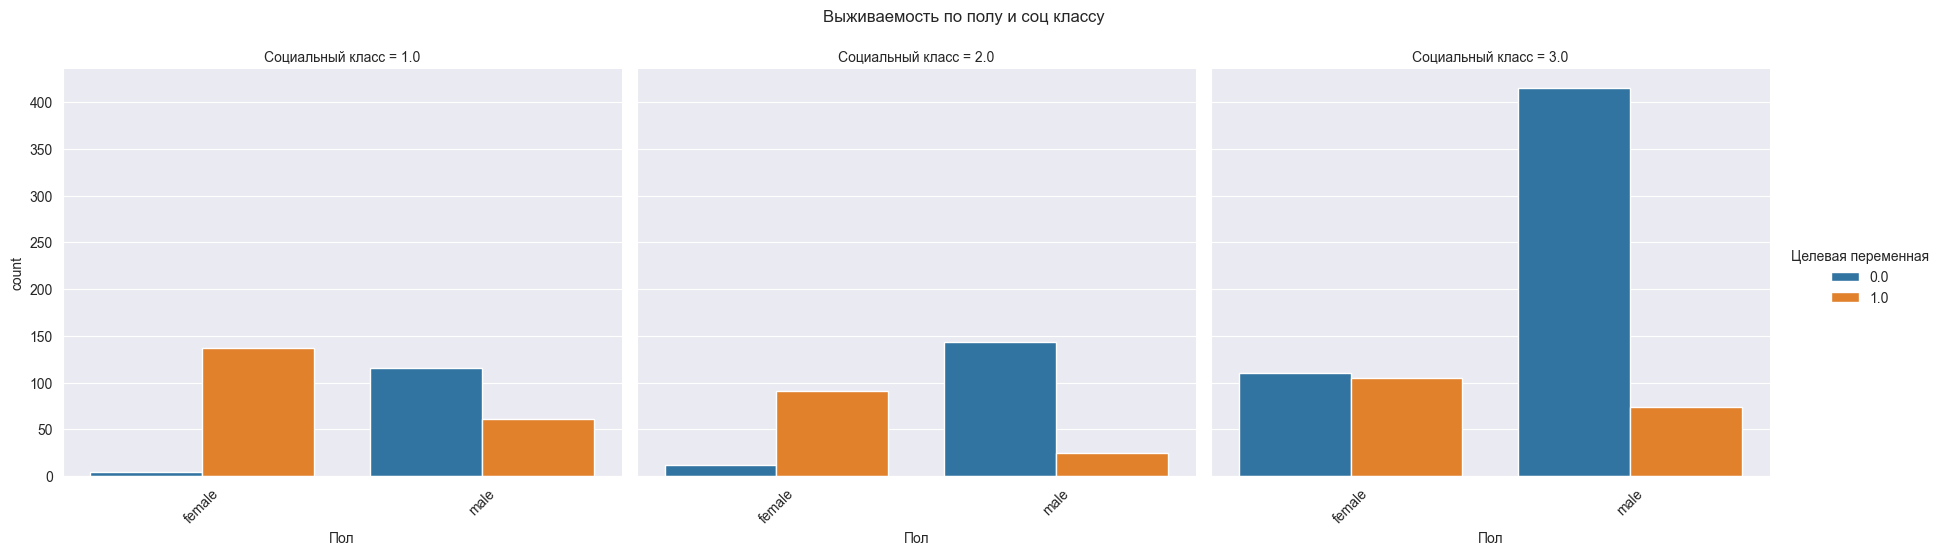

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# например посмотрим сколько пассажиров какого пола выжили или нет по каждому соц классу
g = sns.catplot(x='Пол', hue='Целевая переменная', col='Социальный класс',
                data=df_titanic, kind='count',
                height=5, aspect=1.2)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Выживаемость по полу и соц классу', y=1.05)
plt.show()

Сделаем классификацию при помощи моделей логистической регрессии и SVC - далее выберем из них наилучшую

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# создадим список признаков-фичей, кодировать целевую переменную нам не нужно, так как она уже бинарно закодирована
# Номер билета, БСС, РД - думаю нам не понадобятся
features_list = ['Социальный класс', 'Пол', 'Возраст', 'Стоимость проезда', 'Порт посадки', 'deck']
features_df = df_titanic[features_list]

# разделяем признаки и целевую переменную на обучающие и тестовые выборки
X = pd.get_dummies(features_df)
y = df_titanic['Целевая переменная']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.752895752895753

In [6]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7606177606177607

Модель SVC (support vector classification) показала результаты немного лучше, чем логистическая регрессия (76% точночти против 75%). поэтому применим ее для заполнения требуемой выборки

In [7]:
df_to_predict = pd.read_excel('titanic.xlsx', sheet_name='test')

df_to_predict['Возраст'] = df_to_predict['Возраст'].fillna(df_to_predict.groupby(['Пол', 'Социальный класс'])['Возраст'].transform('median'))
df_to_predict['Возраст'] = df_to_predict['Возраст'].fillna(df_to_predict['Возраст'].median()) # так как для комбинации выше может не быть вариантов, заполняем остальные пропуски общей медианой
df_to_predict['deck'] = df_to_predict['Место'].apply(lambda x: str(x)[0] if pd.notna(x) and x != '' else 'U')

X_pred = df_to_predict[features_list]
X_dummy = pd.get_dummies(X_pred)

training_feature_columns = X.columns.tolist()
X_aligned = pd.DataFrame(0, index=X_dummy.index, columns=training_feature_columns)
for col in X_dummy.columns:
    if col in training_feature_columns:
        X_aligned[col] = X_dummy[col]

predictions = clf.predict(X_aligned)
df_to_predict['Целевая переменная'] = predictions
print(predictions)

with pd.ExcelWriter('titanic.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    df_to_predict.to_excel(writer, sheet_name='test', index=False)


[0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
